In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from imblearn.over_sampling import SMOTE
import sklearn.gaussian_process as gp
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
import tensorflow as tf

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [4]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')

In [5]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
dataset_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

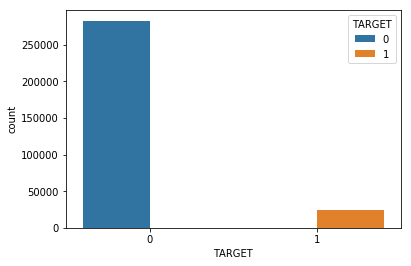

In [7]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train)

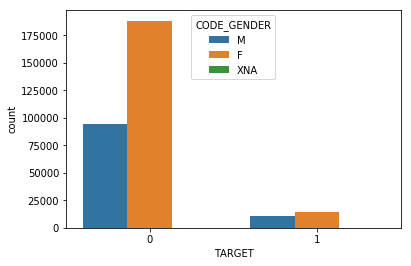

In [8]:
sb.countplot(x='TARGET',hue='CODE_GENDER',data=dataset_train)

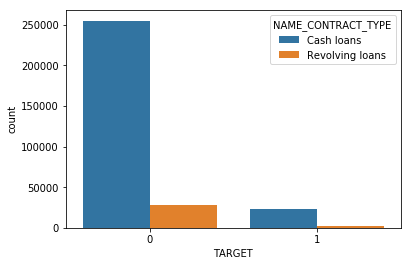

In [9]:
sb.countplot(x='TARGET',hue='NAME_CONTRACT_TYPE',data=dataset_train)

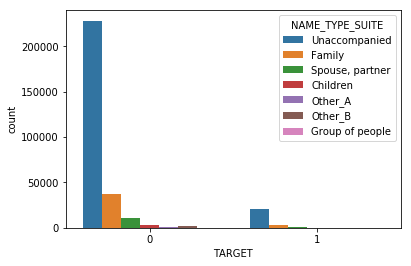

In [10]:
sb.countplot(x='TARGET',hue='NAME_TYPE_SUITE',data=dataset_train)

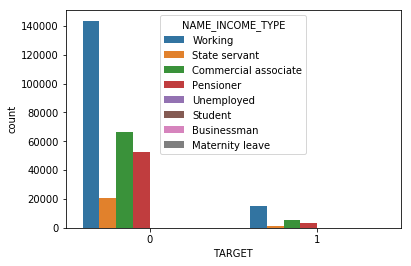

In [11]:
sb.countplot(x='TARGET',hue='NAME_INCOME_TYPE',data=dataset_train)

In [12]:
(dataset_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

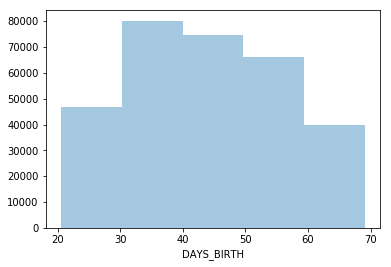

In [13]:
sb.distplot(dataset_train['DAYS_BIRTH']/-365,bins=5,kde=False)

In [14]:
len(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0])


55374

In [15]:
(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0]['TARGET'] == 1).value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

In [16]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
max(dataset_train['DAYS_EMPLOYED'])

365243

In [18]:
len(dataset_train['DAYS_EMPLOYED'] == 365243)

307511

In [19]:
dataset_train['EMP_AN'] = dataset_train['DAYS_EMPLOYED'] == 365243

In [20]:
dataset_train['DAYS_EMPLOYED'] = dataset_train['DAYS_EMPLOYED'].replace({365243: np.nan})

In [21]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [22]:
(abs(dataset_train['DAYS_REGISTRATION']/365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

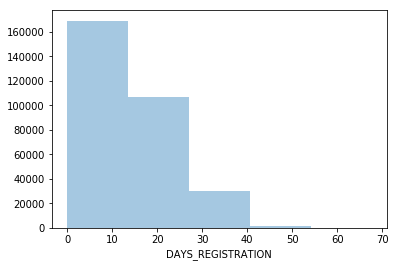

In [23]:
sb.distplot(dataset_train['DAYS_REGISTRATION']/-365,bins=5,kde=False)

In [24]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

80

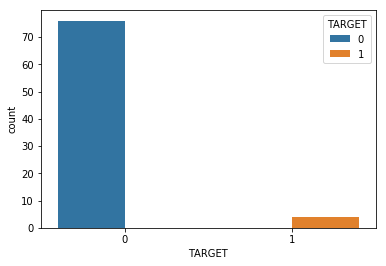

In [26]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50])

In [27]:
dataset_train = dataset_train.drop(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50].index,axis=0)

In [28]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

In [29]:
dataset_train.shape

(307431, 123)

In [30]:
corr = dataset_train.corr(method='pearson')

In [31]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

CNT_CHILDREN - CNT_FAM_MEMBERS
0.8791849055884082
AMT_CREDIT - AMT_ANNUITY
0.7701355325112837
REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9508244177203856
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8606542659268078
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8255558750839367
APARTMENTS_AVG - ELEVATORS_AVG
0.8369526900299763
BASEMENTAREA_AVG - BASEMENTAREA_MODE
0.973496185301789
YEARS_BEGINEXPLUATATION_AVG - YEARS_BEGINEXPLUATATION_MODE
0.97189305389083
YEARS_BUILD_AVG - YEARS_BUILD_MODE
0.9894360514168624
COMMONAREA_AVG - COMMONAREA_MODE
0.9771461116759385
ENTRANCES_AVG - ENTRANCES_MODE
0.9777417653401914
FLOORSMAX_AVG - FLOORSMIN_AVG
0.7424268126795673
LANDAREA_AVG - LANDAREA_MODE
0.9736925929909296
LIVINGAPARTMENTS_AVG - LIVINGAREA_AVG
0.8807913124080583
NONLIVINGAPARTMENTS_AVG - NONLIVINGAPARTMENTS_MODE
0.9693697425066614
NONLIVINGAREA_AVG - NONLIVINGAREA_MODE
0.9660854607189583
APARTMENTS_MODE - ELEVATORS_MODE
0.8262109330460732
FLOORSMAX_MODE - FLOO

In [32]:
#Columnd to remove die to high correlation (Only measured colinearity among pairs of parameters still have to deal
#with multi-colinearity)
columns_to_remove = ['CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_WORK_REGION',
                    'LIVE_CITY_NOT_WORK_CITY','ELEVATORS_AVG','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE','COMMONAREA_MODE','ENTRANCES_MODE','FLOORSMIN_AVG','LANDAREA_MODE',
                    'LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','ELEVATORS_MODE','FLOORSMIN_MODE',
                    'LIVINGAREA_MODE','ELEVATORS_MEDI','FLOORSMIN_MEDI','LIVINGAREA_MEDI','OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE']

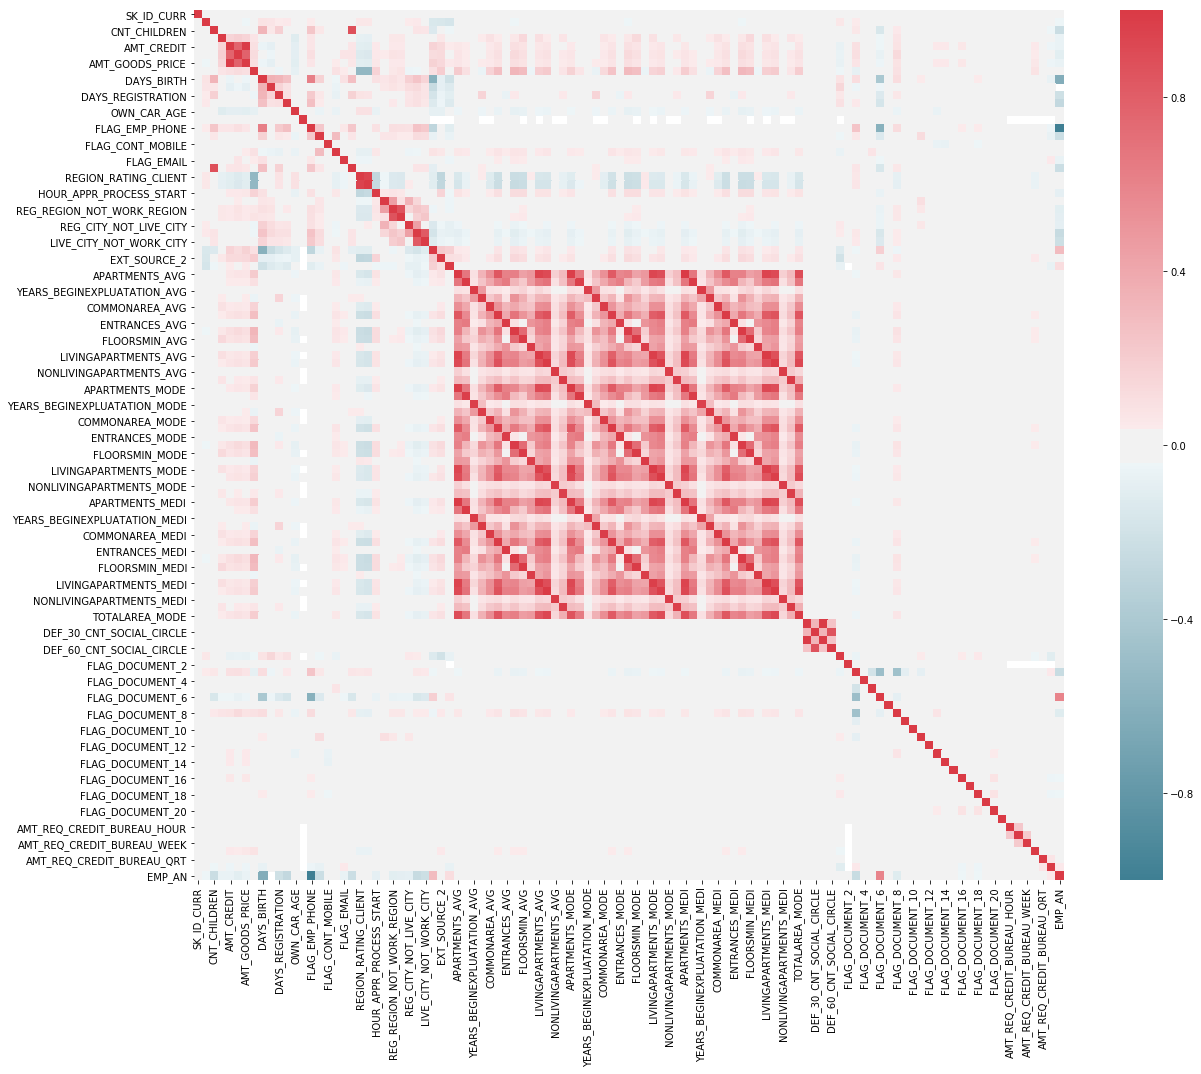

In [33]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [34]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [35]:
dataset_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [36]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    dataset_train[column] = le.fit_transform(dataset_train[column].astype(str))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

Time Elapsed:- 
0.30284905433654785


In [37]:
columns_to_one_hot_encode = ['CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                            'FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','HOUSETYPE_MODE']
starttime = time.time()
for column in columns_to_one_hot_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column].astype(str))
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    df = df.drop([column + "0"],axis=1)
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
dataset_train = dataset_train.drop(columns_to_one_hot_encode,axis=1)
dataset_train.shape

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


CODE_GENDER - 307511 103


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_TYPE_SUITE - 307511 110


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_INCOME_TYPE - 307511 118


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_EDUCATION_TYPE - 307511 123


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_FAMILY_STATUS - 307511 129


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


NAME_HOUSING_TYPE - 307511 135


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OCCUPATION_TYPE - 307511 153


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


ORGANIZATION_TYPE - 307511 211


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WEEKDAY_APPR_PROCESS_START - 307511 218


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


FONDKAPREMONT_MODE - 307511 222


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


WALLSMATERIAL_MODE - 307511 229


/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


HOUSETYPE_MODE - 307511 232


(307511, 220)

In [38]:
dataset_train['DIR'] = dataset_train['AMT_CREDIT']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['AIR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['ACR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_CREDIT']
dataset_train['DAR'] = dataset_train['DAYS_EMPLOYED']/dataset_train['DAYS_BIRTH']

In [40]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(40000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [41]:
from sklearn.preprocessing import StandardScaler, Imputer
imputer = Imputer(strategy='median')
scaler = StandardScaler()
dataset_train_tr = imputer.fit_transform(dataset_train.drop(['SK_ID_CURR','TARGET'],axis=1))
dataset_train_tr = scaler.fit_transform(dataset_train_tr)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [42]:
X = dataset_train_tr
y = dataset_train['TARGET']

In [43]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [44]:
X_test = pd.DataFrame(X_test,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))

In [45]:
X_test.shape

(12000, 222)

In [47]:
y_test.shape

(12000,)

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

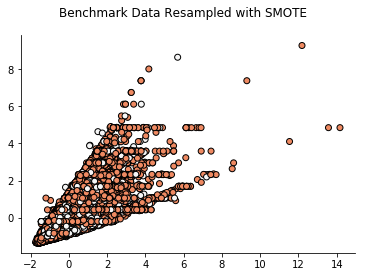

In [48]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_train[:, 5], X_train[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [49]:
#Using SMOTE(Synthetic Minority Oversampling Technique) to handle imbalanced dataset
smote_train = SMOTE(random_state=232)
os_data_X,os_data_y = smote_train.fit_sample(X_train,y_train)
X_train = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']) )
y_train = pd.DataFrame(data=os_data_y,columns=["TARGET"])

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

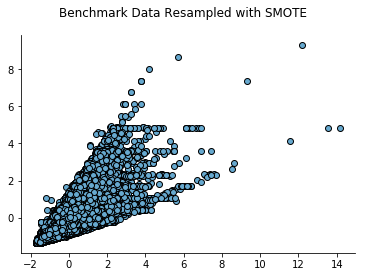

In [50]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_train]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_train.iloc[:, 5], X_train.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [51]:
X_test.shape

(12000, 222)

In [52]:
y_test.shape

(12000,)

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

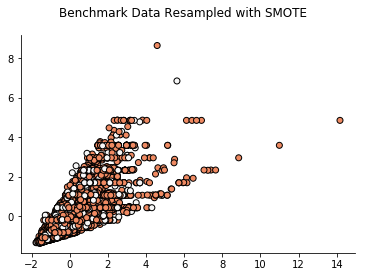

In [53]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_test]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [54]:
smote_test = SMOTE(random_state=232)
os_data_X,os_data_Y = smote_test.fit_sample(X_test,y_test)
X_test = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))
y_test = pd.DataFrame(data=os_data_Y,columns=['TARGET'])

Text(0.5,0.98,'Benchmark Data Resampled with SMOTE')

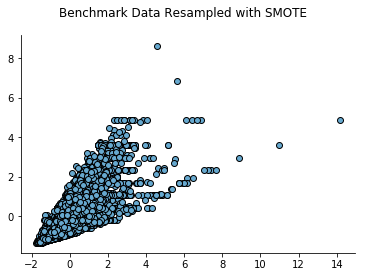

In [55]:
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y_test]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X_test.iloc[:, 5], X_test.iloc[:, 6], c=colors, **kwarg_params)
sb.despine()
plt.suptitle("Benchmark Data Resampled with SMOTE")

In [56]:
X_train.shape

(63824, 222)

In [57]:
y_train.shape

(63824, 1)

In [58]:
X_test.shape

(16176, 222)

In [59]:
y_test.shape

(16176, 1)

In [60]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [61]:
X.shape

(60000, 222)

In [62]:
y.shape

(60000,)

In [63]:
X = pd.concat([X_train,X_test],axis=0)
y = pd.concat([y_train,y_test],axis=0)

In [64]:
y_train = np.array(y_train)
y_train = y_train.ravel()

In [65]:
y_test = np.array(y_test)
y_test = y_test.ravel()

In [66]:
y = np.array(y)
y = y.ravel()

In [67]:
def cross_validation_score(model,X,y,cv=5):
    scores = cross_val_score(model,X,y,cv=cv)
    return sum(scores)/len(scores)

In [90]:
#Use k-fold cross validation to generate estimate of test accuracy

In [91]:
clf = LogisticRegression(C=0.4,max_iter = 1000)
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [92]:
prediction = clf.predict(X_test)

In [93]:
accuracy_score(y_test,prediction)

0.6949802176063303

In [94]:
confusion_matrix(y_test,prediction)

array([[5641, 2447],
       [2487, 5601]])

In [135]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: 

0.6953125

              precision    recall  f1-score   support

         0.0       0.69      0.70      0.70      8088
         1.0       0.70      0.69      0.69      8088

   micro avg       0.69      0.69      0.69     16176
   macro avg       0.69      0.69      0.69     16176
weighted avg       0.69      0.69      0.69     16176



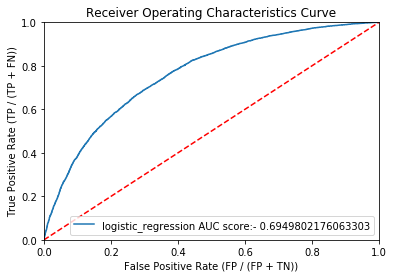

In [95]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

In [ ]:
starttime = time.time()
clf = SVC(gamma=0.001, C=1.0,probability=True,verbose=True)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train SVC classifier:- ")
print(endtime - starttime)

[LibSVM]

In [ ]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

In [ ]:
#Not evaluating cross_val_score because of high training time in SVC
confusion_matrix(y_test,pred).ravel()

In [ ]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],name="svc")

In [96]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [97]:
pred = clf.predict(X_test)

In [98]:
accuracy_score(y_test,pred)

0.6947947576656776

In [99]:
cross_validation_score(clf,X,y,cv=5)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.696325

              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69      8088
         1.0       0.69      0.69      0.69      8088

   micro avg       0.69      0.69      0.69     16176
   macro avg       0.69      0.69      0.69     16176
weighted avg       0.69      0.69      0.69     16176



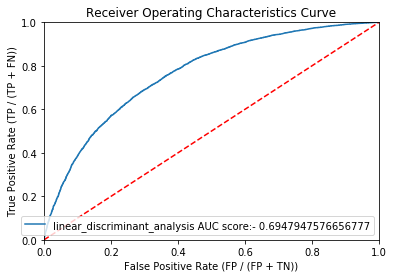

In [100]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],name="linear_discriminant_analysis")

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 10 trees:- 
2.2488670349121094
Accuracy score for 10 trees:- 
0.740417903066271
Confusion matrix for 10 trees:- 
[6453 1635 2564 5524]
OOB score for 10 trees:- 
0.7078685134118827
Classifier report for 10 trees:- 
              precision    recall  f1-score   support

         0.0       0.72      0.80      0.75      8088
         1.0       0.77      0.68      0.72      8088

   micro avg       0.74      0.74      0.74     16176
   macro avg       0.74      0.74      0.74     16176
weighted avg       0.74      0.74      0.74     16176



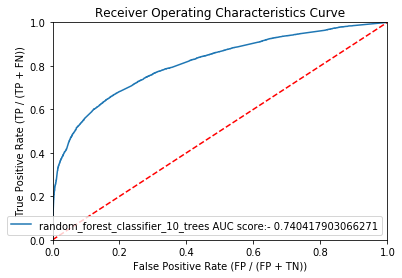

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Time to train 20 trees:- 
4.029281854629517
Accuracy score for 20 trees:- 
0.7638476755687438
Confusion matrix for 20 trees:- 
[6618 1470 2350 5738]
OOB score for 20 trees:- 
0.7437327651040361
Classifier report for 20 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78      8088
         1.0       0.80      0.71      0.75      8088

   micro avg       0.76      0.76      0.76     16176
   macro avg       0.77      0.76      0.76     16176
weighted avg       0.77      0.76      0.76     16176



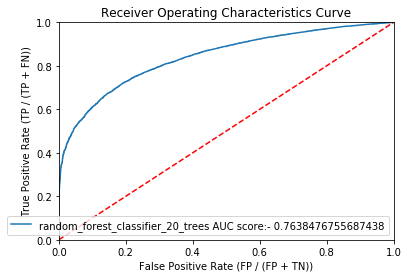

Time to train 30 trees:- 
6.183795928955078
Accuracy score for 30 trees:- 
0.7638476755687438
Confusion matrix for 30 trees:- 
[6633 1455 2365 5723]
OOB score for 30 trees:- 
0.7569879669089997
Classifier report for 30 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.78      8088
         1.0       0.80      0.71      0.75      8088

   micro avg       0.76      0.76      0.76     16176
   macro avg       0.77      0.76      0.76     16176
weighted avg       0.77      0.76      0.76     16176



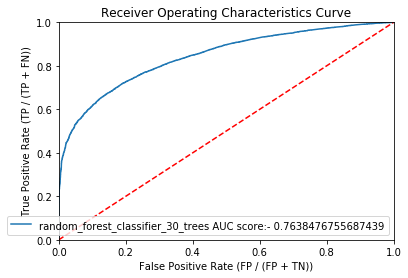

Time to train 40 trees:- 
9.868462800979614
Accuracy score for 40 trees:- 
0.7703387734915925
Confusion matrix for 40 trees:- 
[6747 1341 2374 5714]
OOB score for 40 trees:- 
0.7662008022060667
Classifier report for 40 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78      8088
         1.0       0.81      0.71      0.75      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.77      0.77      0.77     16176
weighted avg       0.77      0.77      0.77     16176



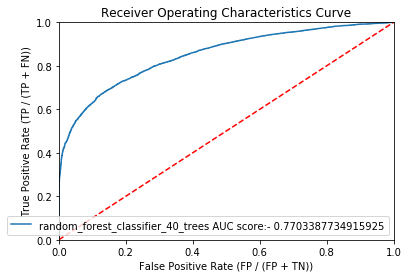

Time to train 50 trees:- 
10.711587905883789
Accuracy score for 50 trees:- 
0.7740479723046488
Confusion matrix for 50 trees:- 
[6796 1292 2363 5725]
OOB score for 50 trees:- 
0.7740505139132615
Classifier report for 50 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.77      0.77      0.77     16176
   macro avg       0.78      0.77      0.77     16176
weighted avg       0.78      0.77      0.77     16176



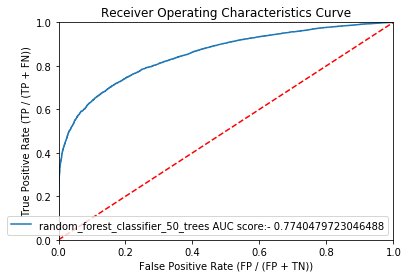

Time to train 100 trees:- 
21.99736213684082
Accuracy score for 100 trees:- 
0.777942631058358
Confusion matrix for 100 trees:- 
[6840 1248 2344 5744]
OOB score for 100 trees:- 
0.7860679368262723
Classifier report for 100 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



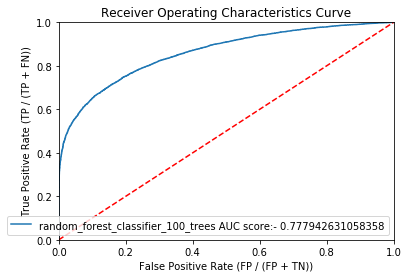

Time to train 150 trees:- 
34.15676999092102
Accuracy score for 150 trees:- 
0.7781280909990109
Confusion matrix for 150 trees:- 
[6864 1224 2365 5723]
OOB score for 150 trees:- 
0.7928208824266734
Classifier report for 150 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.82      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



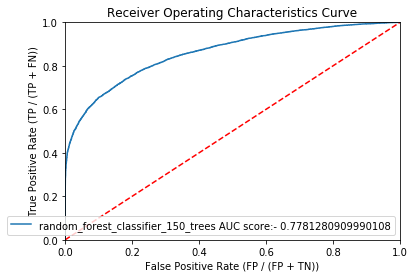

Time to train 200 trees:- 
41.78882622718811
Accuracy score for 200 trees:- 
0.7783753709198813
Confusion matrix for 200 trees:- 
[6877 1211 2374 5714]
OOB score for 200 trees:- 
0.7908623715216846
Classifier report for 200 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.78      0.78      0.78     16176
weighted avg       0.78      0.78      0.78     16176



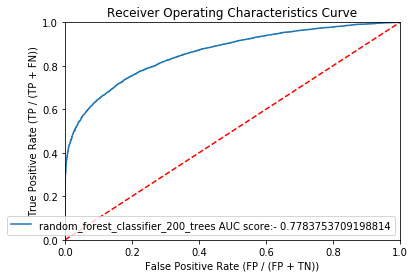

Time to train 250 trees:- 
49.127278089523315
Accuracy score for 250 trees:- 
0.7800445103857567
Confusion matrix for 250 trees:- 
[6899 1189 2369 5719]
OOB score for 250 trees:- 
0.7932909250438707
Classifier report for 250 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



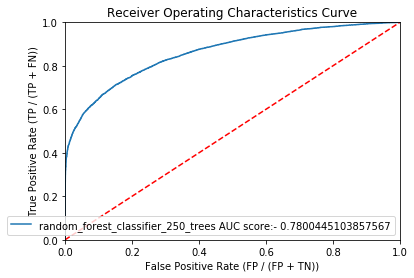

Time to train 300 trees:- 
58.443094968795776
Accuracy score for 300 trees:- 
0.779055390702275
Confusion matrix for 300 trees:- 
[6889 1199 2375 5713]
OOB score for 300 trees:- 
0.795656806217097
Classifier report for 300 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



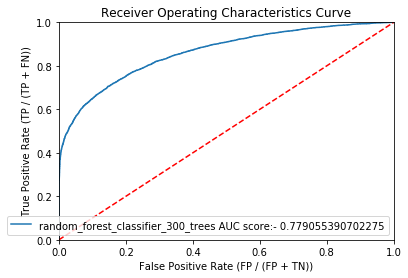

Time to train 400 trees:- 
78.11378693580627
Accuracy score for 400 trees:- 
0.779364490603363
Confusion matrix for 400 trees:- 
[6899 1189 2380 5708]
OOB score for 400 trees:- 
0.7971922787666081
Classifier report for 400 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



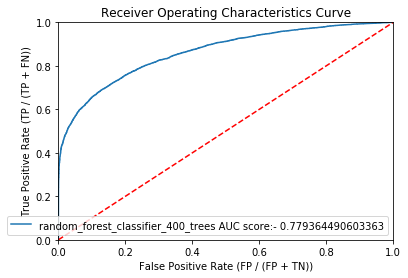

Time to train 500 trees:- 
96.75614094734192
Accuracy score for 500 trees:- 
0.7798590504451038
Confusion matrix for 500 trees:- 
[6900 1188 2373 5715]
OOB score for 500 trees:- 
0.7953747806467787
Classifier report for 500 trees:- 
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



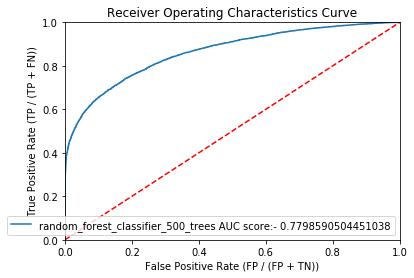

Time to train 750 trees:- 
145.13875770568848
Accuracy score for 750 trees:- 
0.7810336300692384
Confusion matrix for 750 trees:- 
[6905 1183 2359 5729]
OOB score for 750 trees:- 
0.7989001002757583
Classifier report for 750 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



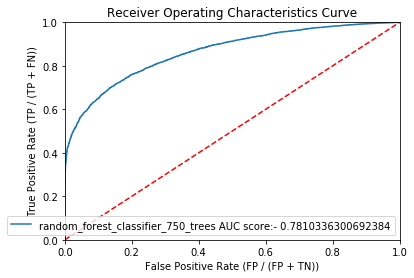

Time to train 1000 trees:- 
195.11474609375
Accuracy score for 1000 trees:- 
0.7810336300692384
Confusion matrix for 1000 trees:- 
[6911 1177 2365 5723]
OOB score for 1000 trees:- 
0.79861807470544
Classifier report for 1000 trees:- 
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80      8088
         1.0       0.83      0.71      0.76      8088

   micro avg       0.78      0.78      0.78     16176
   macro avg       0.79      0.78      0.78     16176
weighted avg       0.79      0.78      0.78     16176



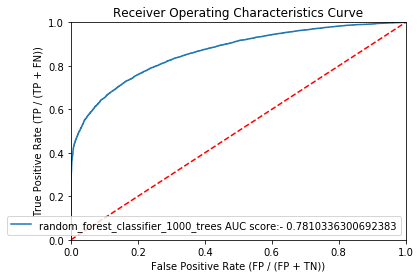

In [105]:
#Have to use Bayesian Optimization to find better set of hyperparameters
#performant value found 400
no_of_trees = [10,20,30,40,50,100,150,200,250,300,400,500,750,1000]
error = []
for noft in no_of_trees:
    starttime = time.time()
    classifier = RandomForestClassifier(n_estimators=noft,max_depth=25,oob_score=True)
    classifier.fit(X_train,y_train)
    endtime = time.time()
    print("Time to train " + str(noft) + " trees:- ")
    print(endtime - starttime)
    error.append(classifier.oob_score_)
    prediction = classifier.predict(X_test)
    print("Accuracy score for " + str(noft) + " trees:- ")
    print(accuracy_score(y_test,prediction))
    print("Confusion matrix for " + str(noft) + " trees:- ")
    print(confusion_matrix(y_test,prediction).ravel())
    print("OOB score for " + str(noft) + " trees:- ")
    print(classifier.oob_score_)
    print("Classifier report for " + str(noft) + " trees:- ")
    generate_classifier_report(classifier,prediction,classifier.predict_proba(X_test)[:,1],"random_forest_classifier_" + str(noft) + "_trees")

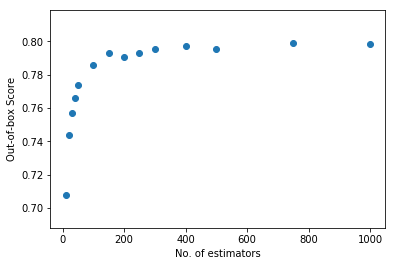

In [106]:
plt.scatter(no_of_trees,error)
plt.xlabel("No. of estimators")
plt.ylabel("Out-of-box Score")
plt.savefig("error_vs_nestimators.jpg")

In [107]:
starttime = time.time()
boosting = XGBClassifier(alpha=1,eval_metric='logloss',max_depth=25,n_estimators=400,verbosity=2)
boosting.fit(X_train,y_train)
endtime = time.time()
print("Time to train XGBClassifier :- ")
print(endtime - starttime)

Time to train XGBClassifier :- 
898.7023451328278


In [108]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

0.7945103857566765

In [109]:
confusion_matrix(y_test,pred)

array([[6933, 1155],
       [2169, 5919]])

In [152]:
cross_validation_score(boosting,X,y,cv=5)

0.7746000000000001

              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      8088
         1.0       0.84      0.73      0.78      8088

   micro avg       0.79      0.79      0.79     16176
   macro avg       0.80      0.79      0.79     16176
weighted avg       0.80      0.79      0.79     16176



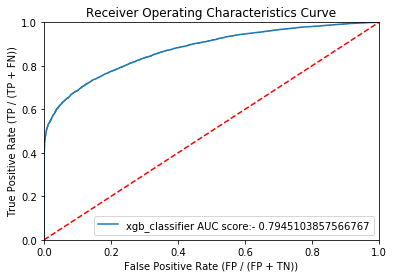

In [110]:
generate_classifier_report(boosting,pred,boosting.predict_proba(X_test)[:,1],'xgb_classifier')

In [141]:
starttime = time.time()
clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='binary',n_estimators=400,max_depth=25)
clf.fit(X_train,y_train)
endtime = time.time()
print("Time to train LightGBM classifier:- ")
print(endtime - starttime)

Time to train LightGBM classifier:- 
42.61828827857971


In [142]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

0.7318333333333333

In [143]:
confusion_matrix(y_test,pred)

array([[7013, 1075],
       [2143, 1769]])

In [148]:
cross_validation_score(clf,X_train,y_train,cv=5)

0.7737146343117121

              precision    recall  f1-score   support

         0.0       0.77      0.87      0.81      8088
         1.0       0.62      0.45      0.52      3912

   micro avg       0.73      0.73      0.73     12000
   macro avg       0.69      0.66      0.67     12000
weighted avg       0.72      0.73      0.72     12000



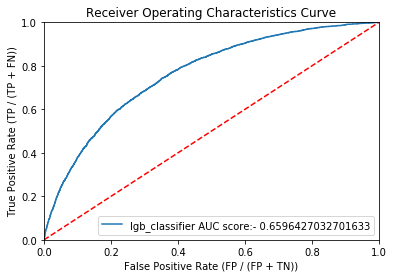

In [144]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],'lgb_classifier')

In [ ]:
X = tf.placeholder(shape=[None,222],dtype=tf.float32)
y = tf.placeholder(shape=[None],dtype=tf.int64)

In [ ]:
weights = {
    'W1': tf.Variable(tf.truncated_normal(shape=[222,140])),
    'W2': tf.Variable(tf.truncated_normal(shape=[140,70])),
    'W3': tf.Variable(tf.truncated_normal(shape=[70,27])),
    'W4': tf.Variable(tf.truncated_normal(shape=[27,1]))
}
biases = {
    'b1': tf.Variable(tf.truncated_normal(shape=[140])),
    'b2': tf.Variable(tf.truncated_normal(shape=[70])),
    'b3': tf.Variable(tf.truncated_normal(shape=[27])),
    'b4': tf.Variable(tf.truncated_normal(shape=[1]))
}

In [ ]:
def get_model(X,weights,biases):
    op1 = tf.add(tf.matmul(X,weights['W1']),biases['b1'])
    relu_op1 = tf.nn.relu(op1) 
    op2 = tf.add(tf.matmul(relu_op1,weights['W2']),biases['b2'])
    relu_op2 = tf.nn.relu(op2)
    op3 = tf.add(tf.matmul(relu_op2,weights['W3']),biases['b3'])
    relu_op3 = tf.nn.relu(op3)
    op4 = tf.add(tf.matmul(relu_op3,weights['W4']),biases['b4'])
    return op4

In [ ]:
pred = get_model(X,weights,biases)
optimizer = tf.train.AdamOptimizer(learning_rate=0.)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_step = optimizer.minimize(loss)

In [ ]:
#Improve accuracy here 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0,10):
        cost = 0
        total_batch = X_train.shape[0]/100
        X_batches = np.array_split(X_train,total_batch)
        y_batches = np.array_split(y_train,total_batch)
        for j in range(0,int(total_batch)):
            g,c = sess.run([train_step,loss],feed_dict={
                X: X_batches[j],
                y: y_batches[j]
            })
            cost = cost + c/total_batch
        print("Epoch:- " + str(i) + " Cost:- " + str(cost))
    correct_prediction = tf.equal(tf.argmax(pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    print("Accuracy:- " + str(accuracy.eval({X: X_test,y: y_test})))